# Automatic Creating of Mining Polygons using Herarchical Clustering Techniques

Hierarchical Clustering es una técnica de agrupación de bloques en clusters de acuerdo a medidas de similaridad y disimilaridad. Existen 2 enfoques:

* *Agglomerative Clustering*: Consiste en partir con los clusters a nivel de bloques, e ir agrupando de acuerdo a un criterio de similaridad. Si no hay un criterio de parada, termina cuando cuando todos los bloques se agrupan en 1 cluster.
* *Divisive Clustering*: Consiste en partir con un cluster, e ir dividiendo en 2 de acuerdo a un criterio de disimilaridad. Si no hay un criterio de parada, termina cuando todos los cluster son 1 bloque.

## Índices de similitud

Existen varias medidas de similitud, pero todas comparten algunas reglas básicas (definición de índice de similitud):

* El índice de similitud es un cociente entre medidas de similitud/disimilitud
\begin{equation*}
    \text{I. Similitud} = \frac{\text{Medida Similitud}}{\text{Medida Disimilitud}}
\end{equation*}
Donde las medidas de similitud y disimilitud dependen de ciertos factores, como tipo de roca o distancia, respectivamente.

* Todos los factores de que determinan la similitud o disimilitud están normalizadas.

* Se usa un valor de pensalización (entre 0 y 1) para los factores categóricos (eg. Tipo de roca, Destino, Periodo de extracción) y una distancia de Minkwski (p-norm) para valores numéricos (eg. Distancia, Ley) y se divide por el mayor valor entre todos estos (para normalizar).

## Algoritmo
El pseudocódigo del clustering tendría la siguiente forma:
 ```mermaid
FOR EACH bench IN dataset 
    SimilarityMatrix = Calculate_Similarity_Matrix()
    AdjencyMatrix = Create_Adjency_Matrix()
    NumerOfClusters = NumberOfBlocks
    MaxNumberOfClusters = NumberOfBlocks/AverageDesiredNumberOfBlocksInCluster \\ Opcional

    WHILE NumberOfClusters > MaxNumberOfClusters
        (i,j) = Find_Most_Similar_Adjacent_Clusters(AdjencyMatrix, SimilarityMatrix)
        IF length(Clusters(i)) + length(Clusters(j)) <= MaxClusterLength THEN
            SimilarityMatrix(i,:) = Min(SimilrityMatrix(i,:), SimilarityMatrix(j,:))
            SimilarityMatrix(j,:) = 0
            AdjancencyMatrix(i,:) = Max(AdjancencyMatrix(i,:), AdjancencyMatrix(j,:))
            AdjancencyMatrix(j,:) = 0
            Clusters(i) = Clusters(i) + Clusters(j)
            NumberOfClusters = NumberOfClusters - 1
        ELSE
            AdjacencyMatrix(i,j) = 0
        ENDIF
    ENDWHILE

    SmallClusters = Get_Small_Clusters(Clusters, MinClustersSize)
    Clusters = Explode_Clusters(SmallClusters)

    FOR NumberOfIterations \\(Mientras hayan corner blocks)
        CornerBlocks = Find_Corner_Blocks()
        Modify_Cluster_IDs(CornerBlocks)
        Clusters = Remove_Empty_Clusters(Clusters)
    ENDFOR
ENDFOR
```

Note que cada vez que agrupamos clusters, es necesario actualizar los índices de similaridad. Hay 3 enfoques para calcular la similaridad entre clusters:
* Single Link
* Complete Link
* Average Link

Tabesh y Askari-Nasab, después de probar todos los enfoques, escogió Complete Link, en el cual la similaridad entre dos clusters está determinada por la similaridad mínima entre todos los pares de bloques entre los dos clusters.

## Comentarios de Tabesh y Askari-Nasab de la implementación
Utilizaron 3 casos de estudio para verificar el rendimiento del algoritmo en distintas situaciones
* Mina de oro de 90.000 bloques de 50x50x15 [pies]. Ésta data se usó para comentar acerca del tiempo de procesamiento y recursos necesarios para correr el algoritmo en un modelo de tamaño real. Hay 4 tipos de material: oro, plata, cobre y sulfuro. Los minerales de oro y plata con alta ley son llevados a un molino, mientras que los de oro de baja ley y de cobre de alta ley son llevados a una planta de lixivización.
* El segundo dataset es una pequeña región de la misma mina, de 874 bloques, usada para ilustrar las características del modelo.
* El tercer dataset es una pequeña región de una "oil sands operation" para ilustrar otra implementación de la técnica de clustering. Consiste en 2792 bloques categorizados en 5 materiales distintos.

Se definen 4 medidas de calidad del clustering, definidas en base a los objetivos para los cuales se formaron los clusters.
* La primera medida es de acuerdo al tamaño del cluster. El objetivo es obtener un tamaño acotado y adecuado, pues clusters demasiado grandes o demasiado pequeños no son convenientes para la planificación minera.
* Las otras 3 medidas son respecto a la homogeneidad del tipo de roca, destino de cada bloque y la ley de cada elemento, llamadas rock unity, destination dilution factor, and grade variation in clusters.

**Rock Unity** (RU) se define como la porción más grande del tipo de roca del cluster.

**Destination Dilution Factor** (DDF) es el tonelaje de los bloques que comparten destino dividido entre el total de tonelaje del cluster.

**Coefficient of Variation** (CV) es un parámetro conocido que es calculado dividiendo la desviación estándar de los valores respecto a su media (de la ley de cada bloque). El promedio del CV del mayor elemento de la mina es otra medida de renidimiento que representa la homogeneidad de la ley en los clusters.


### Control del tamaño de los clusters
El clustering se realiza de "abajo hacia arriba" en términos de tamaño, por lo que el tamaño del cluster se puede controlar relativamente fácil. El tamaño de un nuevo cluster se verifica vs el tamaño máximo cada vez que dos clusters son escogidos para ser unidos. Si se viola esta condición, simplemente los clusters no se unen.

Otro mecanismo de control del tamaño es calcular el número total de clusters dividiendo el número total de bloques entre la media de bloques en caad cluster, y terminar el procedimiento de clustering cuando el número de clusters es igual al número deseado de clusters.

También se puede aplicar un criterio de tamaño mínimo de cluster en el postprocesado, de modo de remover los clusters que quedaron de un tamaño menor a cierto umbral (Barca, Rumantir). La implementación de este criterio puede hacer que algún cluster viole el tamaño máximo, al ser un postprocesado.

[Ver qué sucede cuando sólo un bloque es un cluster y sólo tiene 1 vecino de otro clúster]

### Postprocesado
Se implementa una etapa de postprocesado para refinar la forma de los clusters. Se encarga de dos cambios:
* Remover puntas (sharp corners)
* Remover clusters pequeños

El proceso consiste en que, los clusters de tamaño muy pequeño son desagregados en clusters de 1 solo bloque, y se comienza con el refinamiento de formas. Este es un proceso iterativo en el que los bloques que cumplen que tienen menos (o igual) de un bloque adjacente del mismo cluster y más (estricto) de un bloque adjacente de otro cluster, son desprendidos del cluster original y añadidos a aquel con más vecinos. Este proceso se repite hasta que no hayan más bloques corner.


#### Clustering usando sólo distancia como medida de disimilitud
El índice de similaridad, cuando sólo consideramos la distancia como medida de disimilitud se calcula por
\begin{equation*}
    S_{ij} = \frac{1}{\tilde{D}_{ij}}
\end{equation*}

donde $\tilde{D}_{ij}$ es la distancia normalizada entre los bloques $i$ y $j$. De la misma forma puede ser definida una medida de similaridad de acuerdo a sólo la ley de los bloques.

En general, clusterizar de acuerdo a sólo una de estas medidas no es del todo útil considerando el cómo se procesan los clústers en planta.

### Clustering con más medidas de similitud
El índice de similaridad se calcula como
\begin{equation*}
    S_{ij} = \frac{T_{ij}}{\tilde{D}_{ij}^{W_D} \cdot \tilde{G}_{ij}^{W_G}}
\end{equation*}
donde $T_{ij}$ es la penalización aplicada si los bloques $i$ y $j$ no son enviados al mismo destino y $\tilde{G}_{ij}^{W_D}$ es la diferencia normalizada entre las leyes de los bloques $i$ y $j$.

### Directional Mining Units
La clusterización también se puede usar para crear planes de corto plazo de unidades de minería, control y explosión de mineral. Por ello, la forma de los clusters debiese ser consistente con la dirección de minería.

Por ello, también podemos tomar una medida de similaridad de acuerdo con la dirección de minería, tomando en cuenta la distancia de cada bloque de la recta de la dirección de minería, determinado por dos puntos en el plano coordenado ajustados por el usuario como punto inicial y final de minería. Esto puede resultar en clusters perpendiculares a la dirección de minería. El índice de similitud respecto a la dirección de minería es el siguiente

\begin{equation*}
    S_{ij} = \frac{T_{ij}}{\tilde{D}_{ij}^{W_D} \cdot \tilde{G}_{ij}^{W_G} \cdot \tilde{M}_{ij}^{W_M}}
\end{equation*}

donde 
\begin{equation*}
    M_{i} = \text{sign}\left( (M_i^1)^2 - (M_i^2)^2 \right)\sqrt{\left| (M_i^1)^2 - (M_i^2)^2 \right|}
\end{equation*}
$M_i^1$ y $M_i^2$ es la distancia euclideana al punto de inicio y término de la dirección de minería, respectivamente.

Es poco recomendable usar todos los parámetros de similitud, pues sus efectos se pueden contrarrestar. Por ejemplo, se puede usar el destino o bien la ley como parámetros de similitud, pues usualmente están correlacionados.

### Clustering within boundaries
A veces será necesario crear clusters con ciertas restricciones, por necesidades mineras a corto plazo, mine push backs (área designada para minar en una sola operacion) o designación de zonas mineras. Esto se puede logar manipulando la matriz de adyacencia. Esta se puede multiplicar por otra matriz binaria, indicando aquellos bloques que son de la misma región o no. 

Esta idea puede ser útil para añadir una variable temporal al problema, de modo que, por ejemplo, un cluster minado en un periodo i no se puede juntar con un cluster del periodo i+1.

Otra idea de bounder clustering podría ser tener clusters con absoluta distinción entre mineral y estéril. Sin embargo, esto puede llevar a clusters demasiado pequeños o irregulares, dependiendo de la naturaleza del depósito. El postprocesado (refinamiento de formas) permite flexibilizar (ignorar) cotas estrictas para obtener clusters con mejores formas.


## Implementación

### EDA

In [5]:
import numpy as np
import pandas as pd
import scipy as sp
# import gurobipy as gp
# from gurobipy import Model, GRB, quicksum 
import time
# import os
# import io
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors 
import seaborn as sns

In [6]:
mina_df = pd.read_csv('CP_fases.txt', sep="\s+")
mina_df.rename(columns={'0': 'id'}, inplace=True)

mina_df.head()

,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id
0,491425.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,1
1,491435.0,7456195.0,1968.0,0.266522,1.057851,0.640223,0.021141,0.491924,2.626056,8,0.197908,68.839492,87.471598,0.042976,2,4,2
2,491445.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,3
3,491455.0,7456195.0,1968.0,0.243283,2.427782,0.531022,0.019991,0.396348,2.637350,6,0.399009,68.633711,87.659524,0.050438,2,4,4
4,491435.0,7456205.0,1968.0,0.288929,1.124707,0.712658,0.022003,0.550661,2.615598,8,0.401511,69.001505,87.011938,0.039957,2,4,5


In [7]:
mina_df.info()
mina_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91282 entries, 0 to 91281
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            91282 non-null  float64
 1   y            91282 non-null  float64
 2   z            91282 non-null  float64
 3   au           91282 non-null  float64
 4   cpy          91282 non-null  float64
 5   cueq         91282 non-null  float64
 6   cus          91282 non-null  float64
 7   cut          91282 non-null  float64
 8   density      91282 non-null  float64
 9   material     91282 non-null  int64  
 10  py           91282 non-null  float64
 11  recg_au      91282 non-null  float64
 12  recg_cu      91282 non-null  float64
 13  tasox        91282 non-null  float64
 14  tipomineral  91282 non-null  int64  
 15  fase         91282 non-null  int64  
 16  id           91282 non-null  int64  
dtypes: float64(13), int64(4)
memory usage: 11.8 MB


,x,y,z,au,cpy,cueq,cus,cut,density,material,py,recg_au,recg_cu,tasox,tipomineral,fase,id
count,91282.000000,9.128200e+04,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000,91282.000000
mean,491495.973357,7.456384e+06,2187.059004,0.071752,10.010126,0.196904,0.028348,0.169824,2.493927,2.348502,0.251439,20.471155,25.118488,0.221079,0.910935,2.672871,45641.500000
std,208.751947,2.279014e+02,84.220456,0.083442,29.216819,0.204976,0.045549,0.159794,0.156096,3.589183,0.483646,30.828451,37.775851,0.196674,0.932723,1.125424,26350.987973
min,490965.000000,7.455825e+06,1952.000000,0.000183,0.004594,0.001481,0.000224,0.001481,1.800000,0.000000,0.000000,0.000000,0.000000,0.003291,0.000000,1.000000,1.000000
25%,491345.000000,7.456215e+06,2128.000000,0.016649,0.083105,0.028189,0.005000,0.028189,2.383192,0.000000,0.000000,0.000000,0.000000,0.049170,0.000000,2.000000,22821.250000
50%,491495.000000,7.456385e+06,2208.000000,0.039179,0.348752,0.118358,0.010750,0.118358,2.532500,1.000000,0.000000,0.000000,0.000000,0.168672,1.000000,3.000000,45641.500000
75%,491645.000000,7.456555e+06,2256.000000,0.090219,0.823138,0.309323,0.030120,0.272485,2.626455,5.000000,0.435806,62.872069,78.812326,0.327974,2.000000,4.000000,68461.750000
max,492055.000000,7.456935e+06,2336.000000,1.867645,100.000023,1.446522,0.706230,0.930512,2.728725,82.000000,4.987000,78.284541,90.818887,2.157547,3.000000,4.000000,91282.000000


In [8]:
mina_df.drop(columns=['material', 'au', 'cpy', 'cueq', 'cus', 'py', 'recg_au', 'recg_cu', 'tasox'], inplace=True)

variables_categoricas = mina_df.select_dtypes(include='int64').columns.tolist()
variables_continuas = mina_df.select_dtypes(include='float64').columns.tolist()

print(variables_categoricas)
print(variables_continuas)

['tipomineral', 'fase', 'id']
['x', 'y', 'z', 'cut', 'density']


In [9]:
variables_continuas[3:5]

['cut', 'density']

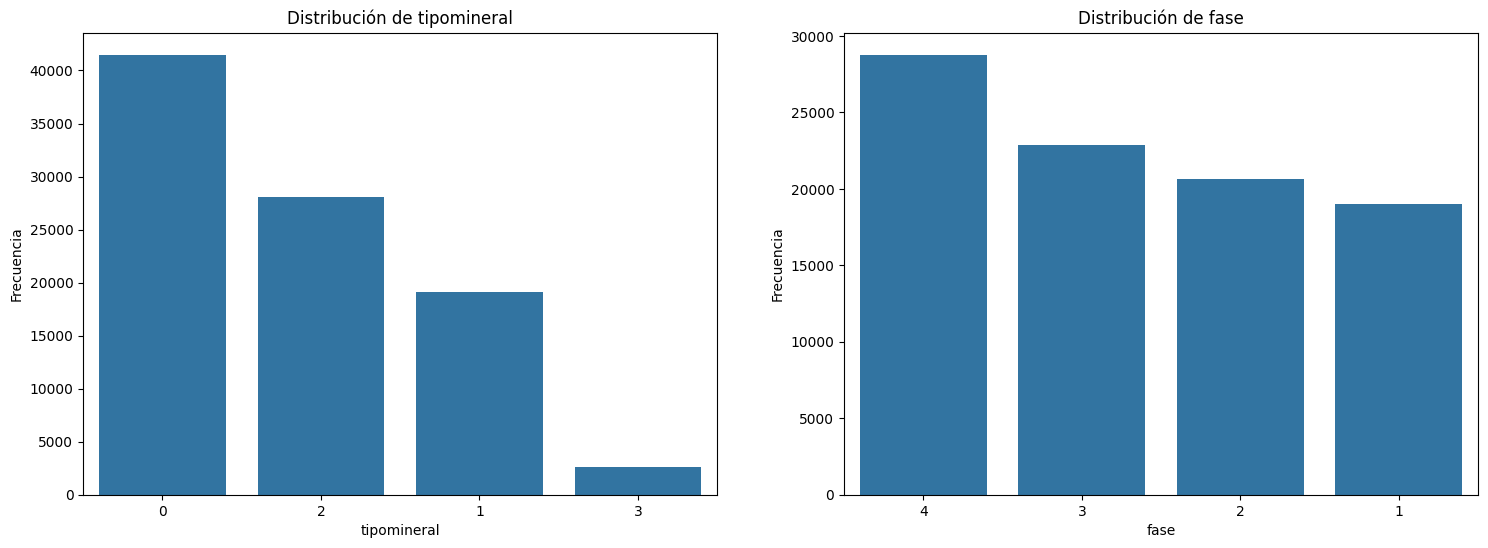

In [10]:
n_cols_int = 2
n_rows_int = 1
fig_int, axes_int = plt.subplots(n_rows_int, 2, figsize=(18,6))
axes_int = axes_int.flatten()

for i, col in enumerate(variables_categoricas[0:2]):
    counts = mina_df[col].value_counts()
    title = f'Distribución de {col}'

    sns.barplot(x=counts.index, y=counts.values, ax=axes_int[i], order=counts.index)
    axes_int[i].set_title(title)
    axes_int[i].set_xlabel(col)
    axes_int[i].set_ylabel('Frecuencia')
    axes_int[i].tick_params(axis='x')

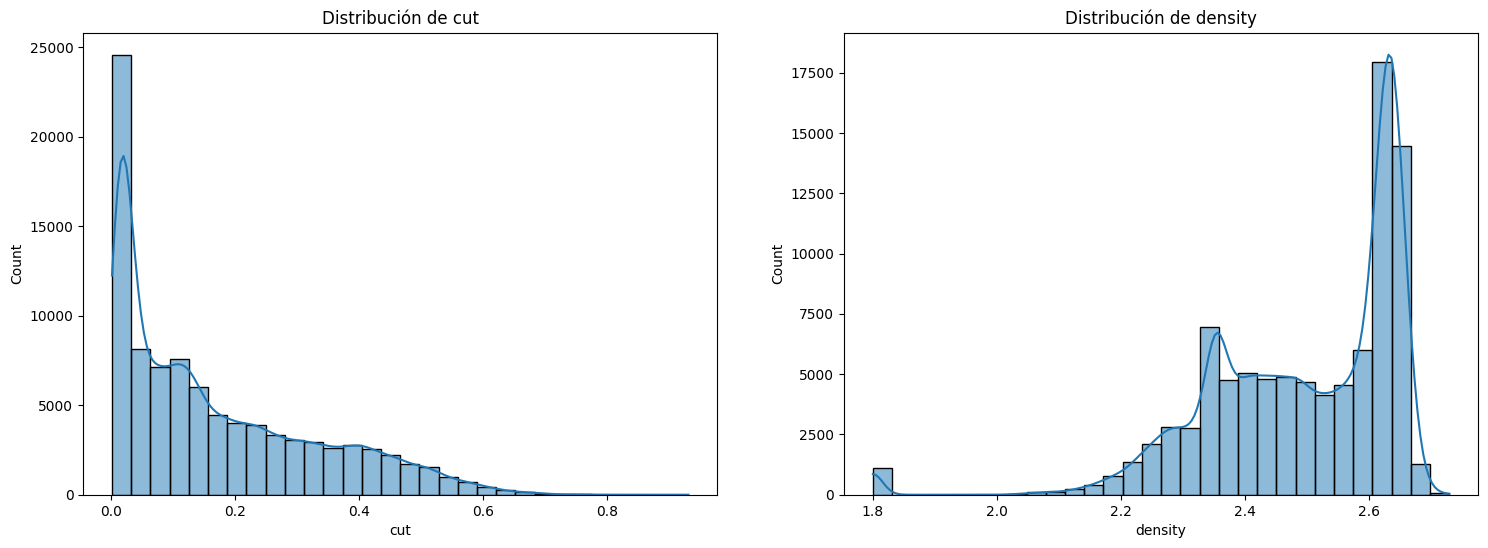

In [11]:
n_cols = 2
n_rows = 1
fig_int, axes_int = plt.subplots(n_rows_int, 2, figsize=(18,6))
axes = axes_int.flatten()

for i, col in enumerate(variables_continuas[3:5]):    
    sns.histplot(mina_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)


In [12]:
# Fase-Banco de prueba: fase=2, z=2096
fase = 2
z = 2096

filtro = (mina_df['fase'] == fase) & (mina_df['z'] == z)
fase_banco = mina_df[filtro].copy()
fase_banco.reset_index(drop=True, inplace=True)

fase_banco.head()

,x,y,z,cut,density,tipomineral,fase,id
0,491485.0,7456175.0,2096.0,0.366266,2.664827,2,2,11875
1,491495.0,7456165.0,2096.0,0.366266,2.664827,2,2,11897
2,491505.0,7456165.0,2096.0,0.361008,2.635160,2,2,11898
3,491495.0,7456175.0,2096.0,0.366266,2.664827,2,2,11900
4,491505.0,7456175.0,2096.0,0.361008,2.635160,2,2,11901


In [13]:
def plot_fase_banco(FaseBanco, column_hue='cut', cmap='plasma', show_block_label=True, show_grid=True):
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    norm = None
    colormap = None
    color_map_discrete = {}
    variables_continuas = FaseBanco.select_dtypes(include='float64').columns.tolist()
    
    col_data = FaseBanco[column_hue]
    if column_hue in variables_continuas:
        is_continuous = True
    else:
        is_continuous = False
    
    if is_continuous:
        vmin = np.min(col_data)
        vmax = np.max(col_data)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        colormap = plt.get_cmap(cmap)
    else:
        if len(col_data.unique())<=20:
            colors = plt.get_cmap('tab20', len(col_data.unique()))
            color_map_discrete = {val: colors(i) for i, val in enumerate(col_data.unique())}
        else:
            colors = plt.get_cmap(cmap, len(col_data.unique()))
            color_map_discrete = {val: colors(i) for i, val in enumerate(col_data.unique())}

    for i, row in FaseBanco.iterrows():
        x_center = row['x']
        y_center = row['y']
        block_value = row[column_hue]
        block_width = 10
        block_height = 10

        x_corner = x_center - block_width / 2
        y_corner = y_center - block_height / 2

        if is_continuous:
            color = colormap(norm(block_value))
        else:
            color = color_map_discrete.get(block_value, 'gray')
        
        rect = patches.Rectangle((x_corner, y_corner), block_width, block_height, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        if show_block_label:
            if is_continuous:
                block_value = np.trunc(block_value*10)/10
            else:
                block_value = int(block_value)
            ax.text(x_center, y_center, str(block_value), ha='center', va='center', fontsize=8, color='black')
    
    if is_continuous:
        x_min = FaseBanco['x'].min() - block_width
        x_max = FaseBanco['x'].max() + block_width
        ax.set_xlim(x_min, x_max)
    else:
        x_min = FaseBanco['x'].min() - block_width
        x_max = FaseBanco['x'].max() + 5*block_width
        ax.set_xlim(x_min, x_max)
    y_min = FaseBanco['y'].min() - block_height
    y_max = FaseBanco['y'].max() + block_height
    ax.set_ylim(y_min, y_max)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Fase {fase} - Banco (Z={z}) - {column_hue}')
    ax.grid(show_grid, color='gray', linestyle='--', linewidth=0.5)

    # ax.plot(fase_banco['x'][0], fase_banco['y'][0], 'ro', markersize=10,)

    if is_continuous:
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=20)
        cbar.set_label(column_hue, rotation=270, labelpad=15)
    else:
        legend_patches = [patches.Patch(color=color, label=str(value)) for value, color in color_map_discrete.items()]
        ax.legend(handles=legend_patches, title=column_hue, loc='upper right', fontsize=8, title_fontsize=10)
    plt.tight_layout()
    plt.show()

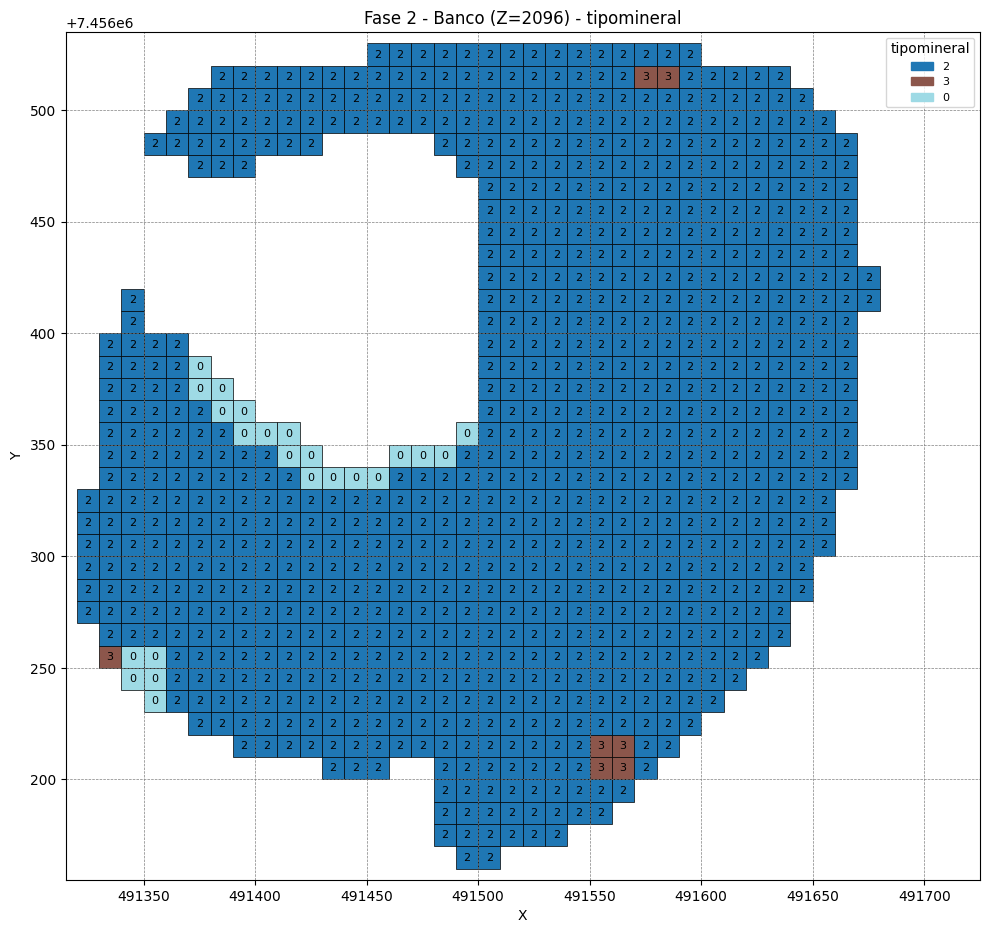

In [14]:
plot_fase_banco(fase_banco, column_hue='tipomineral')

### Implementación del algoritmo

In [149]:
def Calculate_Adjency_Matrix(fasebanco):
    '''
    Crea la matriz de adyacencia de los bloques de la fase-banco respecto a sus coordenadas x e y.
    Devuelve una matriz sparse (CSR).
    '''
    x = fasebanco['x'].values
    y = fasebanco['y'].values

    X1 = np.matlib.repmat(x.reshape(len(x),1), 1, len(x))
    X2 = X1.T
    # X1 = np.triu(X1, k=1)
    # X2 = np.triu(X2, k=1)

    Y1 = np.matlib.repmat(y.reshape(len(y),1), 1, len(y))
    Y2 = Y1.T
    # Y1 = np.triu(Y1, k=1)
    # Y2 = np.triu(Y2, k=1)

    D = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)

    adjency_matrix = (D <= 10) & (D > 0)
    adjency_matrix = sp.sparse.csr_matrix(adjency_matrix).astype(int)
    return adjency_matrix


def Calculate_Similarity_Matrix(
        fasebanco, 
        distancia = True, 
        ley = False, 
        destino = True, 
        peso_distancia = 1, 
        peso_ley = 1, 
        penalizacion_destino = 0.9, 
        tol_ley = 0.0001
        ):
    '''
    Calcula la similaridad entre los bloques de la fase-banco, de acuerdo a distancia, ley o destino.
    No es recomendable que todos los criterios de similaridad sean True y, a su vez, al menos uno de ellos debe ser True.as_integer_ratio
    Devuelve una matriz densa.
    '''
    if not(distancia or ley or destino):
        raise ValueError("Al menos distancia, ley, o destino deben ser True.")

    n = len(fasebanco)

    similarity_matrix = np.zeros((n, n), dtype=float)
    if distancia:
        x = fasebanco['x'].values
        y = fasebanco['y'].values

        X1 = np.matlib.repmat(x.reshape(len(x),1), 1, len(x))
        X2 = X1.T
        # X1 = np.triu(X1, k=1)
        # X2 = np.triu(X2, k=1)

        Y1 = np.matlib.repmat(y.reshape(len(y),1), 1, len(y))
        Y2 = Y1.T
        # Y1 = np.triu(Y1, k=1)
        # Y2 = np.triu(Y2, k=1)

        D = np.sqrt((X1 - X2)**2 + (Y1 - Y2)**2)

        ND = D / np.max(D)
    else:
        ND = 1

    if ley:
        g = fasebanco['cut'].values
        G1 = np.matlib.repmat(g.reshape(len(g),1), 1, len(g))
        G2 = G1.T

        G = np.maximum(np.abs(G1 - G2), tol_ley)

        NG = G / np.max(G)
    else:
        NG = 1

    if destino:
        t = fasebanco['destino'].values
        T1 = np.matlib.repmat(t.reshape(len(t),1), 1, len(t))
        T2 = T1.T
        T = T1 != T2

        T = np.ones((n,n)) - (1-penalizacion_destino)*T*np.ones((n,n))
    else:
        T = 1
    similarity_matrix = np.divide(T,  (np.multiply(ND**peso_distancia, NG**peso_ley)), where=np.ones((n,n)) - np.diag(np.ones(n))  ==1)
    return similarity_matrix

def Hadamard_Product_Sparse(A, B):
    '''
    Calcula el producto de Hadamard (componente a componente) entre una matriz sparse y una densa.
    Devuelve una matriz sparse (CSR).
    '''
    rows, cols = A.nonzero()
    data = []
    res_row = []
    res_col = []

    for i in range(len(rows)):
        row = rows[i]
        col = cols[i]
        data.append(A[row, col] * B[row, col])
        res_row.append(row)
        res_col.append(col)
    resultado_sparse = sp.sparse.csr_matrix((data, (res_row, res_col)), shape=A.shape)
    return resultado_sparse

# def Find_Most_Similar_Adjacent_Clusters_Hadamard(AdjencyMatrix, SimilarityMatrix):
#     '''
#     Encuentra los dos clusters adyacentes más similares entre sí, de acuerdo a la matriz de similaridad y la matriz de adyacencia.
#     Devuelve una lista con los índices de los clusters más similares. Si no encuentra pares similares, devuelve None.
#     Depende de la función Hadamard_Product_Sparse.
#     '''
#     Sim_Matrix = Hadamard_Product_Sparse(AdjencyMatrix, SimilarityMatrix)
#     Sim_Matrix.eliminate_zeros()
#     if Sim_Matrix.nnz == 0:
#         return None
#     most_similar_clusters = []
#     max_similarity = -1

#     rows, cols = Sim_Matrix.nonzero()
#     for i in range(len(rows)):
#         row = rows[i]
#         col = cols[i]
#         if Sim_Matrix[row, col] > max_similarity:
#             max_similarity = Sim_Matrix[row, col]
#             most_similar_clusters = [row, col]
#     return most_similar_clusters

def Find_Most_Similar_Adjacent_Clusters_Hadamard(AdjencyMatrix, SimilarityMatrix):
    '''
    Encuentra los dos clusters adyacentes más similares entre sí, de acuerdo a la matriz de similaridad y la matriz de adyacencia.
    Devuelve una lista con los índices de los clusters más similares. Si no encuentra pares similares, devuelve None.
    Depende de la función Hadamard_Product_Sparse.
    '''
    Sim_Matrix = Hadamard_Product_Sparse(AdjencyMatrix, SimilarityMatrix)
    Sim_Matrix.eliminate_zeros()
    if Sim_Matrix.nnz == 0:
        return None
    Sim_Matrix = Sim_Matrix.tocoo()
    index_max_similarity = np.argmax(Sim_Matrix.data)
    row_max = Sim_Matrix.row[index_max_similarity]
    col_max = Sim_Matrix.col[index_max_similarity]

    return [row_max, col_max]

def Find_Corner_Blocks(FaseBanco, AdjencyMatrix):
    '''
    Encuentra los bloques esquinas de la fase-banco. Se agregaron un par de criterios adicionales respecto a la definición de Tabesh, para bloques con sólo 1 o 2 vecinos.
    Devuelve un diccionario cuyas llaves son los bloques esquina y cuyos valores son los clusters con los que es vecino.
    '''
    n = len(FaseBanco)
    corner_blocks = {}
    rows, cols = AdjencyMatrix.nonzero()
    for i in range(n):
        Mismo_Cluster = 0
        Distinto_Cluster = 0
        Clusters_Vecinos = []
        i_is_row = np.where(rows == i)[0]
        for j in i_is_row:
            if FaseBanco.iloc[i]['cluster'] == FaseBanco.iloc[cols[j]]['cluster']:
                Mismo_Cluster += 1
            else:
                Distinto_Cluster += 1
                Clusters_Vecinos.append(FaseBanco.iloc[cols[j]]['cluster'].astype(int))

        if Distinto_Cluster == 2 and Mismo_Cluster == 0 and (len(np.unique(Clusters_Vecinos)) == 2): ## 2 vecinos
            corner_blocks.update({i: np.sort(Clusters_Vecinos)})
        if (Mismo_Cluster <= 1 and Distinto_Cluster > 1 and (len(np.unique(Clusters_Vecinos)) < len(Clusters_Vecinos))) or (Mismo_Cluster == 0 and Distinto_Cluster == 1):  ## 1 o 3 vecinos
            corner_blocks.update({i: np.sort(Clusters_Vecinos)})
    return corner_blocks

def Find_Corner_Blocks_Tabesh(FaseBanco, AdjencyMatrix):
    '''
    Encuentra los bloques esquinas de la fase-banco. Utiliza el criterio de Tabesh (2013) para definir los bloques esquinas.
    Devuelve un diccionario cuyas llaves son los bloques esquina y cuyos valores son los clusters con los que es vecino.
    '''
    n = len(FaseBanco)
    corner_blocks = {}
    rows, cols = AdjencyMatrix.nonzero()
    for i in range(n):
        Mismo_Cluster = 0
        Distinto_Cluster = 0
        Clusters_Vecinos = []
        i_is_row = np.where(rows == i)[0]
        for j in i_is_row:
            if FaseBanco.iloc[i]['cluster'] == FaseBanco.iloc[cols[j]]['cluster']:
                Mismo_Cluster += 1
            else:
                Distinto_Cluster += 1
                Clusters_Vecinos.append(FaseBanco.iloc[cols[j]]['cluster'].astype(int))
        
        if (Mismo_Cluster <= 1 and Distinto_Cluster > 1 and (len(np.unique(Clusters_Vecinos)) < len(Clusters_Vecinos))):
            corner_blocks.update({i: np.sort(Clusters_Vecinos)})
    return corner_blocks

def Clustering(
        FaseBanco, 
        Average_Desired_Length_Cluster = 30, 
        Max_Cluster_Length = 35, 
        Min_Cluster_Length = 10, 
        PostProcessing = True, 
        Iterations_PostProcessing = 5, 
        Tabesh = True,
        distancia = True,
        ley = False,
        destino = True,
        peso_distancia = 2,
        peso_ley = 0.5,
        penalizacion_destino = 0.8,
        tol_ley = 0.0001
        ):
    '''
    Realiza un clustering jerárquico y agregativo de la fase-banco.
    Average_Desired_Length_Cluster, Max_Cluster_Length y Min_Cluster_Length son restricciones blandas del tamaño de los clusters. Es decir, no siempre se van a satisfacer.
    PostProcessing es una heurística para mejorar la forma de los clusters y para eliminar clusters pequeños.
    Depende de las funciones Calculate_Adjency_Matrix, Calculate_Similarity_Matrix, Find_Most_Similar_Adjacent_Clusters_Hadamard y Find_Corner_Blocks.
    Devuelve un DataFrame de la fase-banco con la columna 'cluster' que indica el cluster al que pertenece cada bloque, y las matrices de adyacencia y de similaridad originales.
    '''
    fase_banco = FaseBanco.copy()
    adj_matrix_sparse = Calculate_Adjency_Matrix(fase_banco)
    adj_matrix_copy = adj_matrix_sparse.copy()
    sim_matrix = Calculate_Similarity_Matrix(fase_banco, distancia=distancia, ley=ley, destino=destino, peso_distancia=peso_distancia, peso_ley=peso_ley, penalizacion_destino=penalizacion_destino, tol_ley=tol_ley)
    sim_matrix_copy = sim_matrix.copy()

    print(f'Nonzero entries of Adjency Matrix: {adj_matrix_sparse.nnz}')
    
    N_Clusters = len(fase_banco)
    n = N_Clusters
    Max_N_Clusters = len(fase_banco) // Average_Desired_Length_Cluster

    fase_banco['cluster'] = np.arange(N_Clusters).astype(int)
    Clusters_Eliminados = 0
    t1 = time.time()
    tries = 0
    while N_Clusters > Max_N_Clusters:
        t1_fmsac = time.time()
        C = Find_Most_Similar_Adjacent_Clusters_Hadamard(adj_matrix_sparse, sim_matrix)
        t2_fmsac = time.time()
        tries += 1
        print(f'Try: {tries}, time: {t2_fmsac-t1_fmsac}')
        if C is None:
            break
        (i,j) = C
        cluster_i = fase_banco[fase_banco['cluster'] == fase_banco.iloc[i]['cluster']]
        cluster_j = fase_banco[fase_banco['cluster'] == fase_banco.iloc[j]['cluster']]

        if len(cluster_i) + len(cluster_j) <= Max_Cluster_Length:
            sim_matrix[i,:] = np.min([sim_matrix[i,:], sim_matrix[j,:]], axis=0)
            sim_matrix[:,i] = np.min([sim_matrix[:,i], sim_matrix[:,j]], axis=0)
            sim_matrix[j,:] = np.zeros(n)
            sim_matrix[:,j] = np.zeros(n)
            
            adj_matrix_sparse = adj_matrix_sparse.tolil()
            adj_matrix_sparse[i,:] = adj_matrix_sparse[i,:].maximum(adj_matrix_sparse[j,:])
            adj_matrix_sparse[:,i] = adj_matrix_sparse[:,i].maximum(adj_matrix_sparse[:,j])

            adj_matrix_sparse[j,:] = np.zeros(n)
            adj_matrix_sparse[:,j] = np.zeros(n)
            # new_row_sparse = sp.sparse.csr_matrix(adj_matrix_sparse[i,:].maximum(adj_matrix_sparse[j,:]), shape=(1,n))
            # before = adj_matrix_sparse[:i]
            # after = adj_matrix_sparse[i+1:]
            # adj_matrix_sparse = sp.sparse.vstack([before, new_row_sparse, after])
            
            # new_col_sparse = sp.sparse.csr_matrix(adj_matrix_sparse[:,i].maximum(adj_matrix_sparse[:,j]), shape=(n,1))
            # before = adj_matrix_sparse[:i]
            # after = adj_matrix_sparse[i+1:]
            # adj_matrix_sparse = sp.sparse.vstack([before, new_row_sparse, after])

            # new_row_sparse = sp.sparse.csr_matrix(np.zeros(n), shape=(1,n))
            # before = adj_matrix_sparse[:j]
            # after = adj_matrix_sparse[j+1:]
            # adj_matrix_sparse = sp.sparse.vstack([before, new_row_sparse, after])
            
            adj_matrix_sparse = adj_matrix_sparse.tocsr()
            adj_matrix_sparse.eliminate_zeros()

            fase_banco.loc[fase_banco['cluster'] == fase_banco.iloc[j]['cluster'], 'cluster'] = fase_banco.iloc[i]['cluster'].astype(int)
            N_Clusters -= 1
            Clusters_Eliminados += 1
        else:
            adj_matrix_sparse[i,j] = 0
            sim_matrix[i,j] = 0
            adj_matrix_sparse.eliminate_zeros()
    t2 = time.time()
    tiempo_agregacion = t2 - t1
    N_Clusters = len(fase_banco['cluster'].unique())
    fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)
    print(f"========PreProcessing Results========")
    print(f"Clusters objetivo: {Max_N_Clusters}")
    print(f"Clusters eliminados: {Clusters_Eliminados}")
    print(f"Total de clusters: {N_Clusters}")
    print(f'Tiempo: {tiempo_agregacion}')

    if PostProcessing:
        ID_Small_Clusters = fase_banco['cluster'].value_counts().loc[fase_banco['cluster'].value_counts() < Min_Cluster_Length].index.tolist()
        max_i_cluster = fase_banco['cluster'].max() + 1
        t1 = time.time()        
        for i in ID_Small_Clusters:
            blocks = fase_banco.loc[fase_banco['cluster'] == i, 'cluster'].index
            for j in blocks:
                fase_banco.loc[j, 'cluster'] = max_i_cluster
                max_i_cluster += 1

        for i in range(Iterations_PostProcessing):
            if Tabesh:
                Corner_Blocks = Find_Corner_Blocks_Tabesh(fase_banco, adj_matrix_copy)
            else:
                Corner_Blocks = Find_Corner_Blocks(fase_banco, adj_matrix_copy)
            
            if len(Corner_Blocks) == 0:
                break
            for i in Corner_Blocks.keys():
                if len(Corner_Blocks[i]) == 2:
                    Cluster_to_insert = Corner_Blocks[i][int(np.round(np.random.rand()))]
                elif len(Corner_Blocks[i]) == 1:
                    choose = [Corner_Blocks[i][0], fase_banco.iloc[i]['cluster']]
                    Cluster_to_insert = choose[int(np.round(np.random.rand()))]
                else:
                    Cluster_to_insert = np.unique_counts(Corner_Blocks[i]).values[np.unique_counts(Corner_Blocks[i]).counts.argmax()]
                fase_banco.loc[i, 'cluster'] = Cluster_to_insert
        t2 = time.time()
        tiempo_postprocesado = t2-t1
        N_Clusters = len(fase_banco['cluster'].unique())
        fase_banco['cluster'] = fase_banco['cluster'].map(lambda x: np.array(range(1,N_Clusters+1))[np.where(fase_banco['cluster'].unique() == x)[0][0]] if x in fase_banco['cluster'].unique() else x)
        
        print(f"========PostProcessing Results========")
        print(f"Total de clusters: {N_Clusters}")
        print(f'Tiempo: {tiempo_postprocesado}')

    return [fase_banco, N_Clusters, adj_matrix_copy, sim_matrix_copy]

In [150]:
# Fase-Banco de prueba: fase=2, z=2096
fase = 4
z = 2160

P = 4
R = 0.85 
C_r = 0.25 
C_m = 2 
C_p = 10 
FTL = 2204.62 

ley_marginal = C_p/((P-C_r)*FTL*R)
ley_corte = ley_marginal*100

filtro = (mina_df['fase'] == fase) & (mina_df['z'] == z)
fase_banco = mina_df[filtro].copy()
fase_banco.reset_index(drop=True, inplace=True)
fase_banco['destino'] = [1 if fase_banco.iloc[i]['cut']>= ley_corte else 0 for i in range(len(fase_banco))]

print(f'Fase Banco Pre-Clustering:')
fase_banco

Fase Banco Pre-Clustering:


,x,y,z,cut,density,tipomineral,fase,id,destino
0,491245.0,7456115.0,2160.0,0.036253,2.409357,0,4,20736,0
1,491255.0,7456095.0,2160.0,0.029409,2.425108,0,4,20743,0
2,491255.0,7456105.0,2160.0,0.036253,2.409357,0,4,20746,0
3,491255.0,7456115.0,2160.0,0.036253,2.409357,0,4,20749,0
4,491235.0,7456125.0,2160.0,0.030454,2.428010,0,4,21148,0
...,...,...,...,...,...,...,...,...,...
1465,491555.0,7456815.0,2160.0,0.219309,2.640086,2,4,32991,1
1466,491565.0,7456815.0,2160.0,0.176820,2.652062,2,4,32992,1
1467,491575.0,7456815.0,2160.0,0.176820,2.652062,2,4,32993,1
1468,491585.0,7456815.0,2160.0,0.176652,2.647398,2,4,32994,1


In [151]:
t1 = time.time()
print(Find_Most_Similar_Adjacent_Clusters_Hadamard(Calculate_Adjency_Matrix(fase_banco), Calculate_Similarity_Matrix(fase_banco)))
t2 = time.time()
print(t2-t1)

[np.int32(0), np.int32(3)]
0.18591642379760742


In [ ]:
print(f'Clustering Tabesh:')
(fase_banco_tabesh, N_Clusters, adj_matrix_copy, sim_matrix_copy) = Clustering(fase_banco, Tabesh=True)
print(f'\n')

print(f'Clustering Mine:')
fase_banco_mine = Clustering(fase_banco, Tabesh=False)[0]
print(f'\n')

print(f'Clustering Sin PostProcesado:')
fase_banco_withouth_post = Clustering(fase_banco, PostProcessing=False)[0]


Clustering Tabesh:
Nonzero entries of Adjency Matrix: 5580
Try: 1, time: 0.07901573181152344
Try: 2, time: 0.08064484596252441
Try: 3, time: 0.08083176612854004
Try: 4, time: 0.07538557052612305
Try: 5, time: 0.0806276798248291
Try: 6, time: 0.07642412185668945
Try: 7, time: 0.07568097114562988
Try: 8, time: 0.08396315574645996
Try: 9, time: 0.07372307777404785
Try: 10, time: 0.07961344718933105
Try: 11, time: 0.07921528816223145
Try: 12, time: 0.07832741737365723
Try: 13, time: 0.07394862174987793
Try: 14, time: 0.07974648475646973
Try: 15, time: 0.0739603042602539
Try: 16, time: 0.07860660552978516
Try: 17, time: 0.0787498950958252
Try: 18, time: 0.07885956764221191
Try: 19, time: 0.07937479019165039
Try: 20, time: 0.07785439491271973
Try: 21, time: 0.08083033561706543
Try: 22, time: 0.0817875862121582
Try: 23, time: 0.0813755989074707
Try: 24, time: 0.07638192176818848
Try: 25, time: 0.07503962516784668
Try: 26, time: 0.08105182647705078
Try: 27, time: 0.0728302001953125
Try: 28, ti

In [45]:
fase_banco_tabesh['cluster'].value_counts().tail(10)

cluster
32    20
34    19
13    19
6     18
21    14
27    12
2     10
26     1
20     1
25     1
Name: count, dtype: int64

In [46]:
fase_banco_mine['cluster'].value_counts().tail(10)

cluster
22    22
11    20
30    20
32    19
13    19
6     18
20    14
25    12
2     10
24     2
Name: count, dtype: int64

In [47]:
fase_banco_withouth_post['cluster'].value_counts().tail(10)

cluster
13    22
11    21
12    21
33    19
6     18
21    14
26    12
2     10
25     2
20     1
Name: count, dtype: int64

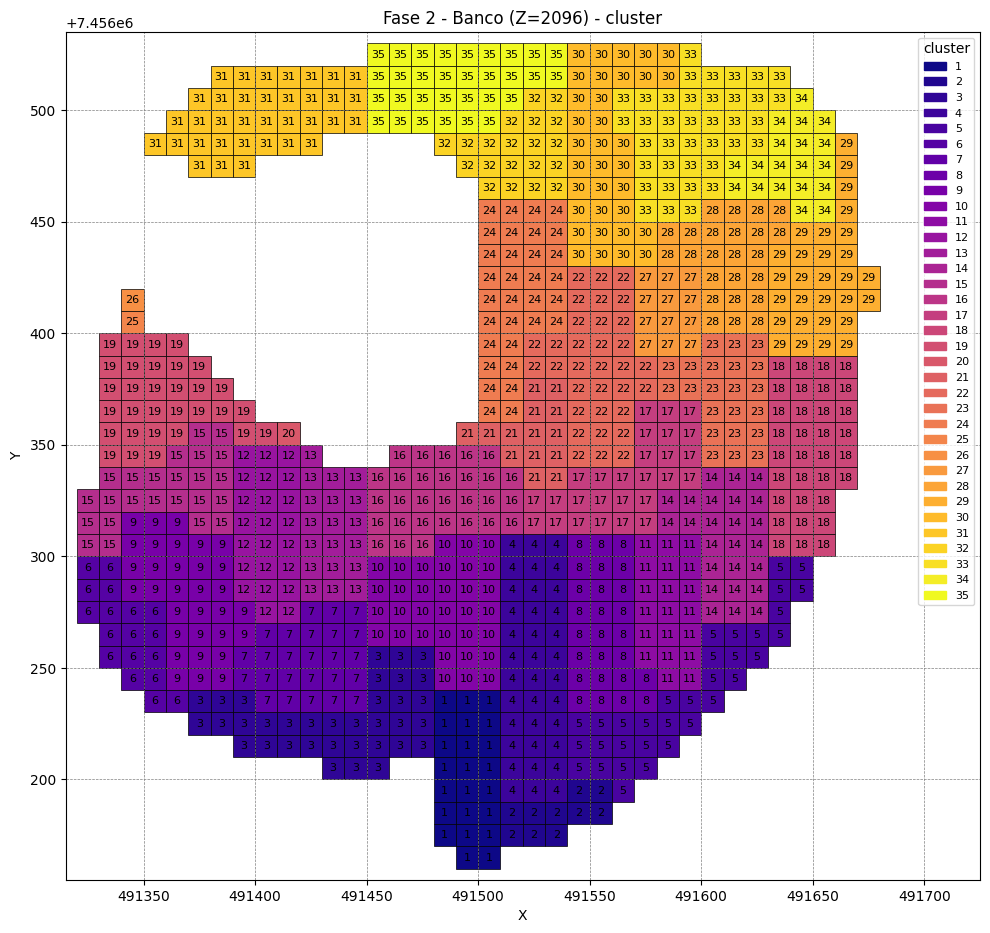

In [48]:
plot_fase_banco(fase_banco_tabesh, column_hue='cluster')

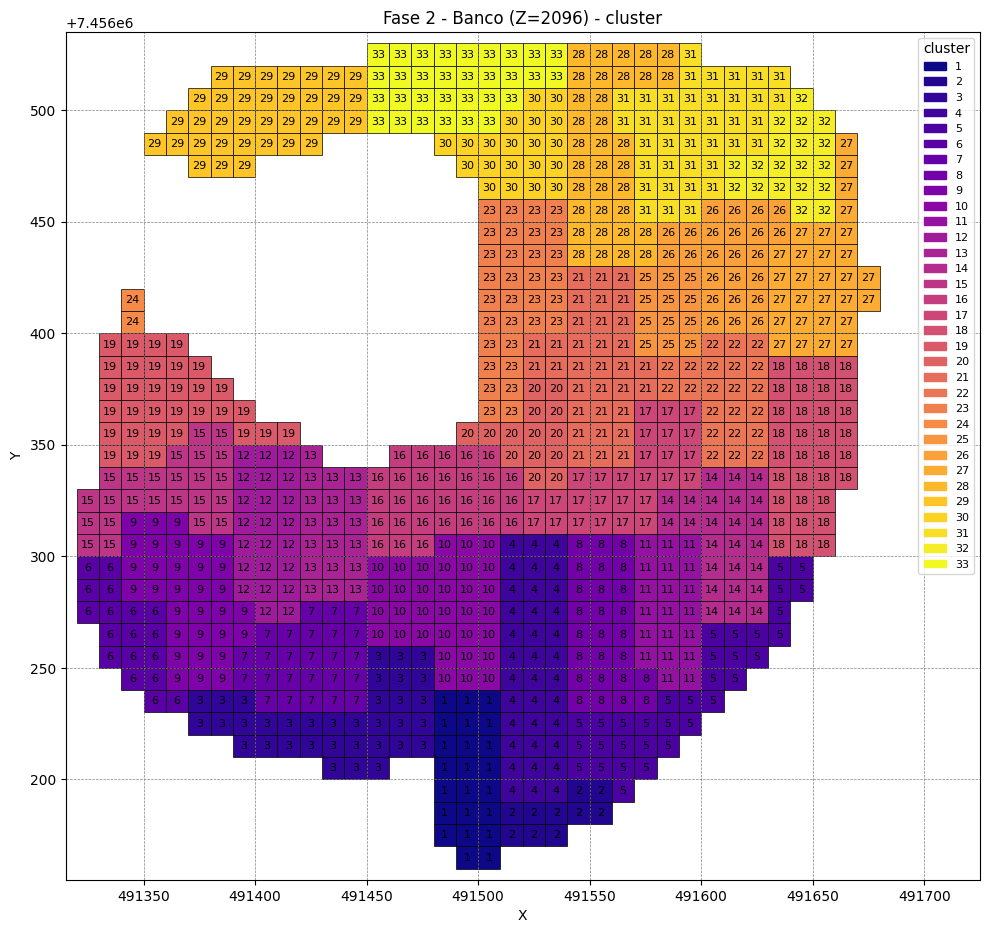

In [49]:
plot_fase_banco(fase_banco_mine, column_hue='cluster')

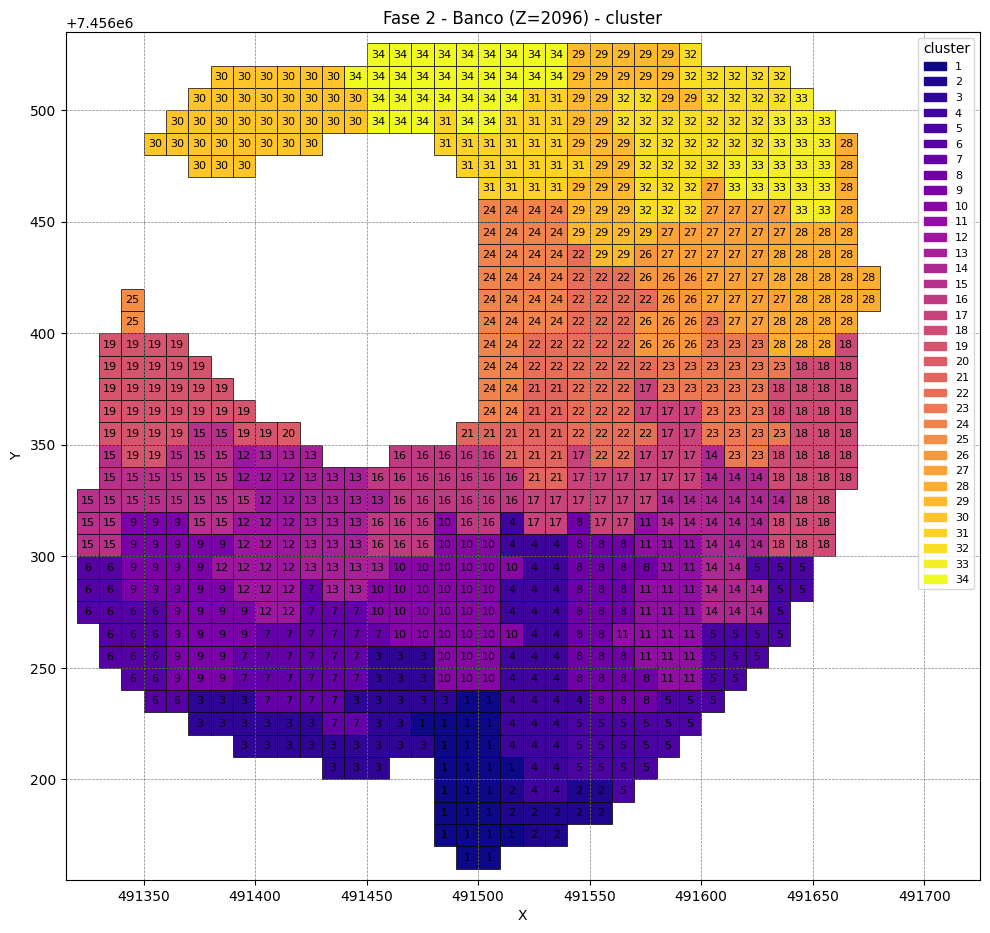

In [50]:
plot_fase_banco(fase_banco_withouth_post, column_hue='cluster')

# Clustering de toda la mina

In [ ]:
P = 4
R = 0.85 
C_r = 0.25 
C_m = 2 
C_p = 10 
FTL = 2204.62 

ley_marginal = C_p/((P-C_r)*FTL*R)
ley_corte = ley_marginal*100

print(f'Ley de corte usada: {ley_corte}')
fases = mina_df['fase'].unique()

mina_clusterizada = None
contador_bancos = 1
contador_clusters = 0
for fase in fases:
    bancos = mina_df[mina_df['fase'] == fase]['z'].unique().copy()
    for banco in bancos:
        print(f'\n')
        print(f'Fase-Banco N° {fase}-{banco}')
        fase_banco = mina_df[(mina_df['fase'] == fase) & (mina_df['z'] == banco)].copy()
        fase_banco.reset_index(drop=True, inplace=True)
        fase_banco['destino'] = [1 if fase_banco.iloc[i]['cut']>= ley_corte else 0 for i in range(len(fase_banco))]
        
        print(f'Tamaño de la fase-banco: {len(fase_banco)}')
        (fase_banco, n_clusters) = Clustering(fase_banco)[0:2]
        if contador_bancos==1:
            mina_clusterizada = fase_banco.copy()
        else:
            mina_clusterizada = pd.concat([mina_clusterizada, fase_banco], ignore_index=True)

        contador_bancos +=1
        contador_clusters += n_clusters
        

print(f'Clusters creados: {contador_clusters}')

mina_clusterizada

Ley de corte usada: 0.14230365786216148


Fase-Banco N° 1
Tamaño de la fase-banco: 706
Nonzero entries of Adjency Matrix: 1347
========PreProcessing Results========
Clusters objetivo: 23
Clusters eliminados: 682
Total de clusters: 28
Tiempo: 11.52713418006897
========PostProcessing Results========
Total de clusters: 30
Tiempo: 0.27789855003356934


Fase-Banco N° 2
Tamaño de la fase-banco: 393
Nonzero entries of Adjency Matrix: 731
========PreProcessing Results========
Clusters objetivo: 13
Clusters eliminados: 379
Total de clusters: 15
Tiempo: 3.6505517959594727
========PostProcessing Results========
Total de clusters: 17
Tiempo: 0.18915247917175293


Fase-Banco N° 3
Tamaño de la fase-banco: 864
Nonzero entries of Adjency Matrix: 1631
========PreProcessing Results========
Clusters objetivo: 28
Clusters eliminados: 831
Total de clusters: 39
Tiempo: 17.449206829071045
========PostProcessing Results========
Total de clusters: 47
Tiempo: 0.4143662452697754


Fase-Banco N° 4
Tamaño de la fa

,x,y,z,cut,density,tipomineral,fase,id,destino,cluster
0,491425.0,7456205.0,1968.0,0.550661,2.615598,2,4,1,1,1
1,491435.0,7456195.0,1968.0,0.491924,2.626056,2,4,2,1,1
2,491445.0,7456195.0,1968.0,0.396348,2.637350,2,4,3,1,1
3,491455.0,7456195.0,1968.0,0.396348,2.637350,2,4,4,1,1
4,491435.0,7456205.0,1968.0,0.550661,2.615598,2,4,5,1,1
...,...,...,...,...,...,...,...,...,...,...
91277,491685.0,7456635.0,2304.0,0.083556,2.303350,0,1,87389,0,12
91278,491605.0,7456695.0,2304.0,0.015000,2.390991,0,1,88275,0,13
91279,491605.0,7456705.0,2304.0,0.015000,2.401936,0,1,88276,0,14
91280,491615.0,7456695.0,2304.0,0.015000,2.390991,0,1,88295,0,15
